In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
import numpy as np

def density_Gaussian(mean_vec,covariance_mat,x_set):
    """ Return the density of multivariate Gaussian distribution
        Inputs: 
            mean_vec is a 1D array (like array([,,,]))
            covariance_mat is a 2D array (like array([[,],[,]]))
            x_set is a 2D array, each row is a sample
        Output:
            a 1D array, probability density evaluated at the samples in x_set.
    """
    d = x_set.shape[1]  
    inv_Sigma = np.linalg.inv(covariance_mat)
    det_Sigma = np.linalg.det(covariance_mat)
    density = []
    for x in x_set:
        x_minus_mu = x - mean_vec
        exponent = - 0.5*np.dot(np.dot(x_minus_mu,inv_Sigma),x_minus_mu.T)
        prob = 1/(((2*np.pi) ** (d/2))*np.sqrt(det_Sigma))*np.exp(exponent)
        density.append(prob)
    density_array = np.array(density)  
    
    return density_array 

def get_data_in_file(filename):
    """ 
    Read the height/weight data and the labels from the given file as arrays 
    """
    with open(filename, 'r') as f:
        data = []
        # read the data line by line
        for line in f: 
            data.append([int(x) for x in line.split()]) 
            
    # store the height/weight data in x and the labels in y        
    data_array = np.array(data)     
    y = data_array[:,0]   # labels
    x = data_array[:,1:3]   # height/weight data
    
    return (x, y)

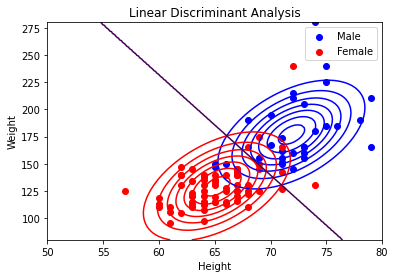

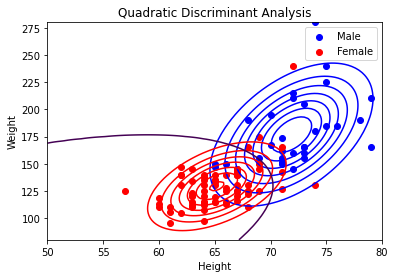

Rates:  0.11818181818181818 0.10909090909090909


In [37]:
import numpy as np
import matplotlib.pyplot as plt

def discrimAnalysis(x, y):
    """
    Estimate the parameters in LDA/QDA and visualize the LDA/QDA models
    
    Inputs
    ------
    x: a N-by-2 2D array contains the height/weight data of the N samples
    
    y: a N-by-1 1D array contains the labels of the N samples 
    
    Outputs
    -----
    A tuple of five elments: mu_male,mu_female,cov,cov_male,cov_female
    in which mu_male, mu_female are mean vectors (as 1D arrays)
             cov, cov_male, cov_female are covariance matrices (as 2D arrays)
    Besides producing the five outputs, you need also to plot 1 figure for LDA 
    and 1 figure for QDA in this function         
    """
    ### TODO: Write your code here
    
    #totals
    N = len(y)

    N_m = np.sum(y == 1)
    N_f = np.sum(y == 2)

    mu_m = np.sum(x * (y == 1).reshape(N, -1), 0) / N_m
    mu_f = np.sum(x * (y == 2).reshape(N, -1), 0) / N_f

    E_m = np.matmul(((x-mu_m) * (y == 1).reshape(N, -1)).T, ((x-mu_m) * (y == 1).reshape(N, -1))) / N_m
    E_f = np.matmul(((x-mu_f) * (y == 2).reshape(N, -1)).T, ((x-mu_f) * (y == 2).reshape(N, -1))) / N_f
    E = (N_m * E_m + N_f * E_f) / N
    
    #visual
    height_m, weight_m, height_f, weight_f = ([] for idx in range(4))

    for n in range(0, N):
      if y[n] == 1:
        height_m.append(x[n][0])
        weight_m.append(x[n][1])
      else:
        height_f.append(x[n][0])
        weight_f.append(x[n][1])
    
    x_axis = np.linspace(50, 80, 100)   
    y_axis = np.linspace(80, 280, 100) 
    X, Y = np.meshgrid(x_axis, y_axis)

    LDA_m, QDA_m, LDA_f, QDA_f = ([] for idx in range(4))

    x_val = X[0].reshape(100, 1)
    for n in range(100):
      points = np.concatenate((x_val, Y[n].reshape(100, 1)), 1)
      
      LDA_m.append(density_Gaussian(mu_m, E, points))
      QDA_m.append(density_Gaussian(mu_m, E_m, points))

      LDA_f.append(density_Gaussian(mu_f, E, points))
      QDA_f.append(density_Gaussian(mu_f, E_f, points))    
    
    plt.figure(1)
    plt.contour(X, Y, LDA_m, colors='b')
    plt.contour(X, Y, LDA_f, colors='r')
    plt.scatter(height_m, weight_m, color = 'b')
    plt.scatter(height_f, weight_f, color = 'r')
    LDA_boundary = np.asarray(LDA_m) - np.asarray(LDA_f)
    plt.contour(X, Y, LDA_boundary, [0])
    plt.title('Linear Discriminant Analysis')
    plt.xlabel('Height')
    plt.ylabel('Weight')
    plt.legend(['Male', 'Female'], loc = 'best')
    plt.show()

    plt.figure(2)
    plt.contour(X, Y, QDA_m, colors='b')
    plt.contour(X, Y, QDA_f, colors='r')
    plt.scatter(height_m, weight_m, color = 'b')
    plt.scatter(height_f, weight_f, color = 'r')
    QDA_boundary = np.asarray(QDA_m) - np.asarray(QDA_f)
    plt.contour(X, Y, QDA_boundary, [0])
    plt.title('Quadratic Discriminant Analysis')
    plt.xlabel('Height')
    plt.ylabel('Weight')
    plt.legend(['Male', 'Female'], loc = 'best')
    plt.show()
    
    return (mu_m, mu_f, E, E_m, E_f)
    

def misRate(mu_m, mu_f, E, E_m, E_f, x, y):
    """
    Use LDA/QDA on the testing set and compute the misclassification rate
    
    Inputs
    ------
    mu_male,mu_female,cov,cov_male,mu_female: parameters from discrimAnalysis
    
    x: a N-by-2 2D array contains the height/weight data of the N samples  
    
    y: a N-by-1 1D array contains the labels of the N samples 
    
    Outputs
    -----
    A tuple of two elements: (mis rate in LDA, mis rate in QDA )
    """
    ### TODO: Write your code here
    N = len(y)

    LDA_y_m = np.dot(x, np.dot(np.linalg.inv(E), mu_m.reshape(2,1))) - 0.5 * np.dot(mu_m.T, np.dot(np.linalg.inv(E), mu_m.reshape(2,1)))
    LDA_y_f = np.dot(x, np.dot(np.linalg.inv(E), mu_f.reshape(2,1))) - 0.5 * np.dot(mu_f.T, np.dot(np.linalg.inv(E), mu_f.reshape(2,1)))
    LDA_y = (LDA_y_f > LDA_y_m) + 1
    mis_lda = np.sum(y.reshape(N, -1) != LDA_y) / N

    QDA_y_m = np.diagonal(-0.5 * np.dot(np.dot(x - mu_m, np.linalg.inv(E_m)), (x - mu_m).T) - 0.5 * np.log(np.linalg.det(E_m)))
    QDA_y_f = np.diagonal(-0.5 * np.dot(np.dot(x - mu_f, np.linalg.inv(E_f)), (x - mu_f).T) - 0.5 * np.log(np.linalg.det(E_f)))
    QDA_y = (QDA_y_f > QDA_y_m) + 1
    mis_qda = np.sum(y != QDA_y) / N

    return (mis_lda, mis_qda)


if __name__ == '__main__':
    
    # load training data and testing data
    x_train, y_train = get_data_in_file('/content/gdrive/My Drive/ECE368/trainHeightWeight.txt')
    x_test, y_test = get_data_in_file('/content/gdrive/My Drive/ECE368/testHeightWeight.txt')
    
    # parameter estimation and visualization in LDA/QDA
    mu_m, mu_f, E, E_m, E_f = discrimAnalysis(x_train, y_train)
    
    # misclassification rate computation
    mis_LDA, mis_QDA = misRate(mu_m, mu_f, E, E_m, E_f, x_test, y_test)

    print('Rates: ', mis_LDA, mis_QDA)